In [42]:
import pypsa
import pandas as pd

In [43]:
# =====================
# Datenaufbereitung: Konvertiere Excel zu CSV
# =====================

import zipfile
import xml.etree.ElementTree as ET

def read_simple_xlsx(filename):
    """Liest eine einfache XLSX-Datei ohne openpyxl"""
    with zipfile.ZipFile(filename, 'r') as z:
        # Lade die Shared Strings (falls vorhanden)
        try:
            shared_strings_xml = z.read('xl/sharedStrings.xml')
            strings_root = ET.fromstring(shared_strings_xml)
            shared_strings = [elem.text for elem in strings_root.findall('.//{http://schemas.openxmlformats.org/spreadsheetml/2006/main}t')]
        except:
            shared_strings = []
        
        # Lade das erste Sheet
        sheet_xml = z.read('xl/worksheets/sheet1.xml')
        root = ET.fromstring(sheet_xml)
        
        # Extrahiere Daten
        data = []
        namespace = {'ns': 'http://schemas.openxmlformats.org/spreadsheetml/2006/main'}
        
        for row in root.findall('.//ns:row', namespace):
            row_data = []
            for cell in row.findall('.//ns:c', namespace):
                cell_type = cell.get('t')
                value_elem = cell.find('ns:v', namespace)
                
                if value_elem is not None:
                    if cell_type == 's':  # String aus shared strings
                        idx = int(value_elem.text)
                        row_data.append(shared_strings[idx] if idx < len(shared_strings) else '')
                    else:  # Numerischer Wert
                        try:
                            row_data.append(float(value_elem.text))
                        except:
                            row_data.append(value_elem.text)
                else:
                    row_data.append(None)
            
            if row_data:
                data.append(row_data)
        
        return data

# Konvertiere die Excel-Datei nur beim ersten Mal oder wenn CSV nicht existiert
import os
if not os.path.exists('ninja_pv_51.1601_13.csv') or os.path.getmtime('ninja_pv_51.1601_13.7660.xlsx') > os.path.getmtime('ninja_pv_51.1601_13.csv'):
    print("Konvertiere ninja_pv Excel-Datei...")
    data = read_simple_xlsx('ninja_pv_51.1601_13.7660.xlsx')
    
    # Erste Zeile = Header, Rest = Daten
    headers = data[0] if data else []
    values = data[1:] if len(data) > 1 else []
    
    # Erstelle DataFrame und normalisiere
    df = pd.DataFrame(values, columns=headers)
    
    # Normalisiere Werte auf 0-1 (PyPSA erwartet normalisierte Werte für p_max_pu)
    if df['electricity'].max() > 1.1:
        df['electricity'] = df['electricity'] / df['electricity'].max()
    
    # Speichere als CSV
    df.to_csv('ninja_pv_51.1601_13.csv', index=False)
    print(f"✓ Konvertiert: {df.shape[0]} Stunden, Volllaststunden: {df['electricity'].sum():.0f} h/Jahr")
else:
    print("✓ ninja_pv_51.1601_13.csv bereits vorhanden")

✓ ninja_pv_51.1601_13.csv bereits vorhanden


In [44]:
# =====================
# Grundparameter Standort
# =====================

roof_area = 5500                 # Gebäudefläche [m²]
number_transporter = 78          # Anzahl E-Fahrzeuge
capacitiy_battery_transporter = 40  # Batteriekapazität je Fahrzeug [kWh]
inhouse_pv = 0.35                # Max. PV-Leistung auf dem Dach [MW]

# =====================
# Wärmebedarfe (vereinfachte Annahmen)
# =====================

DHW_load_hourly = roof_area * 0.008 / 8760      # Trinkwarmwasser [MW]
Thermal_load_hourly = roof_area * 0.05 / 8760   # Raumheizung [MW]

# =====================
# Zeitprofile
# =====================

# Lade das ninja_pv Solar-Profil für Deutschland (51.16°N, 13°E)
renewable_profile_solar = (pd.read_csv("ninja_pv_51.1601_13.csv", usecols=["electricity"])
    ["electricity"].astype(float))  # Stündliches, normiertes PV-Erzeugungsprofil

custom_load_profile_MW = (pd.read_csv("jahreslastgang_dhl (1).csv", usecols=["load_kWh"])
    ["load_kWh"].astype(float) / 1000) # Standortlastgang, von kWh/h in MW umgerechnet

# PyPSA-Netz
network = pypsa.Network()
network.set_snapshots(range(8760))  # Stündliche Auflösung übers Jahr

# Busse
network.add("Bus", name="electricity")
network.add("Bus", name="heat_0")   # Trinkwarmwasser
network.add("Bus", name="heat_1")   # Raumheizung


# Erzeugung & Netz
network.add("Generator", "PV", bus="electricity",
    p_nom=inhouse_pv,
    p_max_pu=renewable_profile_solar,
    marginal_cost=5)

network.add("Generator", "Grid", bus="electricity",
    p_nom=1.3,           # Netzanschlussleistung [MW]
    marginal_cost=300)


# Lasten (Anteile des Gesamtprofils)
network.add("Load", "Electric_Load",bus="electricity", p_set=custom_load_profile_MW * 0.15)
network.add("Load", "Fleet_Load",bus="electricity", p_set=custom_load_profile_MW * 0.7)
network.add("Load", "DHW_Load",bus="heat_0", p_set=custom_load_profile_MW * 0.05)
network.add("Load", "Thermal_Load",bus="heat_1", p_set=custom_load_profile_MW * 0.1)


# Wärmepumpen
network.add("Link", "Heat_Pump_0", bus0="electricity", bus1="heat_0",
            efficiency=3, p_nom=0.045) # roof_area* 8 [W/qm] -Recherche

network.add("Link", "Heat_Pump_1", bus0="electricity", bus1="heat_1",
            efficiency=3, p_nom=0.22) # roof_area* 40 [W/qm]  -Recherche


# Wärmespeicher
network.add("Store", "DHW_Storage",
            bus="heat_0", e_nom_extendable=True,
            e_cyclic=True, standing_loss=0.005)

network.add("Store", "Thermal_Storage",
            bus="heat_1", e_nom_extendable=True,
            e_cyclic=True, standing_loss=0.005)

In [45]:
# Optimierung mit verfügbarem Solver (HiGHS ist in PyPSA enthalten)
network.optimize(solver_name='highs')

Index(['electricity', 'heat_0', 'heat_1'], dtype='object', name='name')
Index(['Heat_Pump_0', 'Heat_Pump_1'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 300.82it/s]
INFO:linopy.io: Writing time: 0.25s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-90v9vu9_ has 148922 rows; 70082 cols; 245282 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 3e+00]
  Cost    [5e+00, 3e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 1e+00]
Presolving model
19438 rows, 41065 cols, 60229 nonzeros  0s
Dependent equations search running on 19435 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
19435 rows, 38870 cols, 60220 nonzeros  0s
Presolve reductions: rows 19435(-129487); columns 38870(-31212); nonzeros 60220(-185062) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.8830722588e+05 Pr: 19435(300.866) 0s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70082 primals, 148922 duals
Objective: 1.92e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      26316     1.9231242107e+05 Pr: 0(0); Du: 0(5.94706e-12) 2s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-90v9vu9_
Model status        : Optimal
Simplex   iterations: 26316
Objective value     :  1.9231242098e+05
P-D objective error :  2.4062392787e-14
HiGHS run time      :          1.75


('ok', 'optimal')

In [46]:
# Jährlicher PV-Ertrag [MWh]
pv_generation = network.generators_t.p["PV"].sum()

# Gesamtstromverbrauch des Standorts [MWh]
total_load = network.loads_t.p.sum(axis=1).sum()

# Jährlicher Strombezug aus dem öffentlichen Netz [MWh]
grid_import = network.generators_t.p["Grid"].clip(lower=0).sum()

# Autarkiegrad [-]: Anteil des Stromverbrauchs, der ohne Netzbezug gedeckt wird
autarky = 1 - grid_import / total_load

# Elektrische Energieaufnahme der Wärmepumpe für Raumheizung [MWh]
el_heat = network.links_t.p0["Heat_Pump_1"].abs().sum()

# Erzeugte thermische Energie für Raumheizung [MWh]
th_heat = network.links_t.p1["Heat_Pump_1"].sum()

# Jahresarbeitszahl der Heizungs-Wärmepumpe [-]
JAZ_heat = th_heat / el_heat

# Elektrische Energieaufnahme der Wärmepumpe für Trinkwarmwasser [MWh]
el_dhw = network.links_t.p0["Heat_Pump_0"].abs().sum()

# Erzeugte thermische Energie für Trinkwarmwasser [MWh]
th_dhw = network.links_t.p1["Heat_Pump_0"].sum()

# Jahresarbeitszahl der Trinkwarmwasser-Wärmepumpe [-]
JAZ_dhw = th_dhw / el_dhw

# Jährlicher Energiebedarf der E-Fahrzeugflotte [MWh]
fleet_energy = network.loads_t.p["Fleet_Load"].sum()


In [47]:
print(f"PV-Ertrag: {pv_generation:.1f} MWh")
print(f"Autarkiegrad: {autarky*100:.1f} %")
print(f"JAZ Heizung: {JAZ_heat:.2f}")
print(f"JAZ DHW: {JAZ_dhw:.2f}")
print(f"E-Flotte Energiebedarf: {fleet_energy:.1f} MWh")


PV-Ertrag: 306.0 MWh
Autarkiegrad: 38.6 %
JAZ Heizung: -3.00
JAZ DHW: -3.00
E-Flotte Energiebedarf: 724.5 MWh


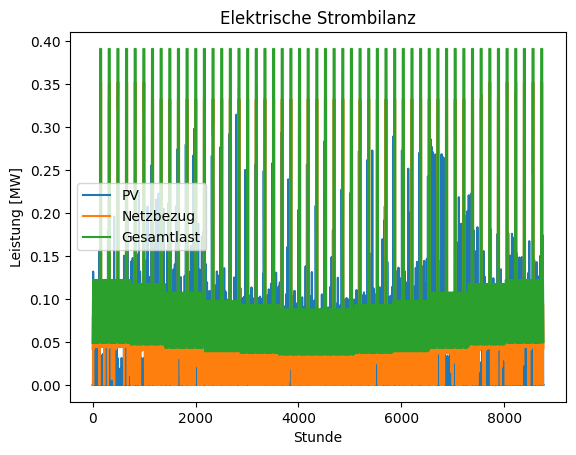

In [48]:
#Diagramme
import matplotlib.pyplot as plt

plt.figure()                                  # Neue Figure erstellen

network.generators_t.p["PV"].plot(label="PV")        # PV-Erzeugungsleistung
network.generators_t.p["Grid"].plot(label="Netzbezug")  # Leistung aus dem Stromnetz
network.loads_t.p.sum(axis=1).plot(label="Gesamtlast")  # Summe aller elektrischen Lasten

plt.ylabel("Leistung [MW]")                   # y-Achse: Leistung
plt.xlabel("Stunde")                          # x-Achse: Zeit (stündlich)
plt.legend()                                  # Legende anzeigen
plt.title("Elektrische Strombilanz")          # Diagrammtitel
plt.show()                                    # Plot anzeigen


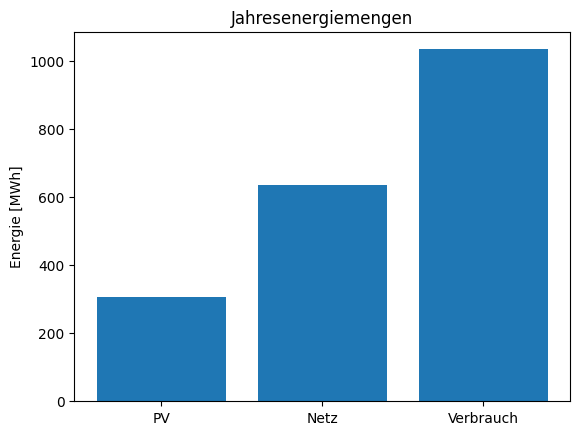

In [49]:
pv_energy = network.generators_t.p["PV"].sum()                 # Gesamtenergie der PV-Anlage [MWh]
grid_energy = network.generators_t.p["Grid"].clip(lower=0).sum()  # Bezogene Energie aus dem Netz [MWh]
total_load = network.loads_t.p.sum(axis=1).sum()               # Gesamtstromverbrauch aller Lasten [MWh]

plt.figure()                                                    # Neue Figure erstellen
plt.bar(                                                       # Balkendiagramm
    ["PV", "Netz", "Verbrauch"],                                # Kategorien
    [pv_energy, grid_energy, total_load]                       # Zugehörige Energiemengen
)
plt.ylabel("Energie [MWh]")                                    # y-Achse: Energie
plt.title("Jahresenergiemengen")                               # Diagrammtitel
plt.show()                                                     # Plot anzeigen


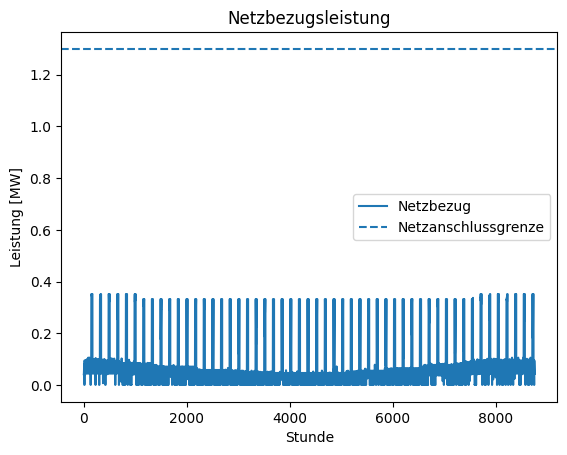

In [50]:
plt.figure()  # Neue Abbildung

network.generators_t.p["Grid"].plot(label="Netzbezug")  # Zeitlicher Verlauf der Netzleistung

plt.axhline(
    y=network.generators.loc["Grid", "p_nom"],  # Maximale Netzanschlussleistung
    linestyle="--", label="Netzanschlussgrenze")

plt.ylabel("Leistung [MW]")  # y-Achse
plt.xlabel("Stunde")         # x-Achse
plt.legend()                 # Legende anzeigen
plt.title("Netzbezugsleistung")  # Diagrammtitel
plt.show()                   # Plot anzeigen


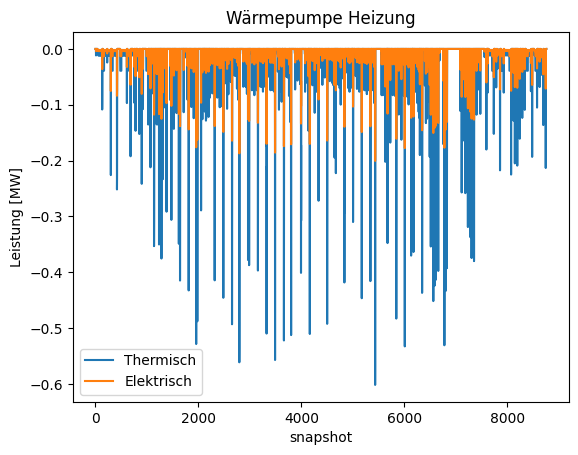

In [51]:
# Zeitlicher Verlauf der Heiz-Wärmepumpe (thermische Abgabe vs. elektrische Aufnahme)
plt.figure()

# Thermische Leistung (Wärmeabgabe der Wärmepumpe)
network.links_t.p1["Heat_Pump_1"].plot(label="Thermisch")

# Elektrische Leistungsaufnahme (Vorzeichen gedreht für Vergleich)
(-network.links_t.p0["Heat_Pump_1"]).plot(label="Elektrisch")

# Achsenbeschriftung
plt.ylabel("Leistung [MW]")

# Legende und Titel
plt.legend()
plt.title("Wärmepumpe Heizung")

# Plot anzeigen
plt.show()


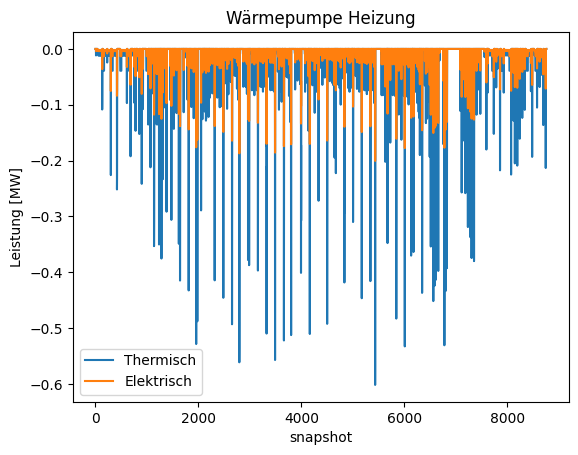

In [52]:
plt.figure()  # Neue Abbildung

network.links_t.p1["Heat_Pump_1"].plot(label="Thermisch")      # Abgegebene Wärmeleistung
(-network.links_t.p0["Heat_Pump_1"]).plot(label="Elektrisch") # Elektrische Aufnahmeleistung

plt.ylabel("Leistung [MW]")  # y-Achse
plt.legend()                 # Legende anzeigen
plt.title("Wärmepumpe Heizung")  # Diagrammtitel
plt.show()                   # Plot anzeigen


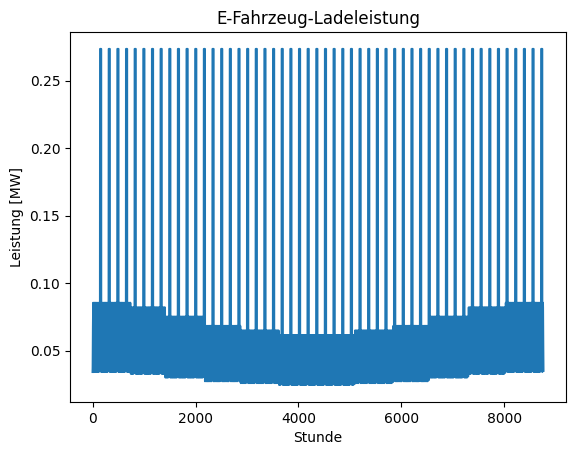

In [53]:
plt.figure()  # Neue Abbildung

network.loads_t.p["Fleet_Load"].plot()  # Ladeleistung der E-Fahrzeugflotte über die Zeit

plt.ylabel("Leistung [MW]")             # y-Achse
plt.xlabel("Stunde")                    # x-Achse
plt.title("E-Fahrzeug-Ladeleistung")    # Diagrammtitel
plt.show()                              # Plot anzeigen


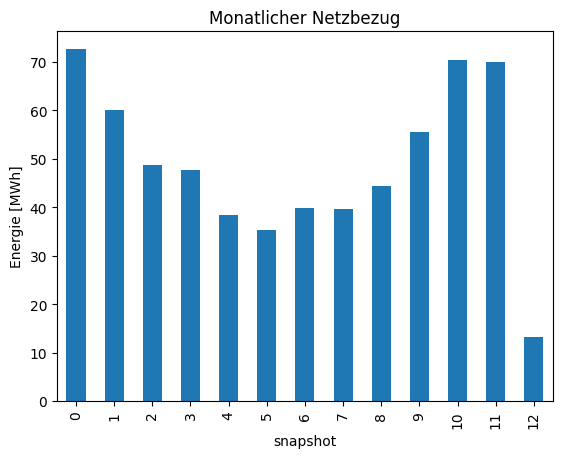

In [54]:
monthly = network.generators_t.p["Grid"].groupby(
    network.snapshots // 720          # Gruppierung in „Monate“ à 720 h (vereinfachte Monatsannahme)
).sum()                               # Aufsummieren zur Monatsenergie (MWh)

plt.figure()                          # Neue Abbildung
monthly.plot(kind="bar")             # Balkendiagramm des monatlichen Netzbezugs

plt.ylabel("Energie [MWh]")           # y-Achse: Energie
plt.title("Monatlicher Netzbezug")    # Diagrammtitel
plt.show()                            # Plot anzeigen
